# Maintenance du Modèle

### Fréquence nécessaire de mise à jour du modèle de segmentation.

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

Pour cela, nous devons recalculer toutes les features en fonction d'une période donnée. Le script réalisant ces calculs ce trouve ci-dessous

In [1]:
import os
from time import time
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn import (preprocessing,
                     manifold,
                     decomposition)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances_argmin_min
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import seaborn as sns
import scipy.cluster.hierarchy as shc

In [3]:
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    """The haversine formula makes it possible to determine the distance of the great circle 
        between two points of a sphere, from their longitudes and latitudes.

    Parameters
    ----------
    lat1, lat2 : float
        Latitudes of the 2 coordinate points to compare. 
    lng1, lng2 : float
        Longitudes of the 2 coordinate points to compare.
    degrees : boolean
        If True, converts radians to degrees.
    """
    # Radius of the earth in miles
    r = 3956 
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Haversine formula
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [4]:
def stabilityCheck(nb_iter, K, model, data, labels):
    
    scores_time = pd.DataFrame(columns=["Iteration",
                                        "silhouette", "ARI", "Time"])
    
    for i in range(nb_iter):
        t0 = time.time()
        estimator = make_pipeline(MinMaxScaler(), model).fit(data)
        fit_time = time.time() - t0
        
        scores_time.loc[len(scores_time)] = [i,silhouette_score(data,
                                                                  estimator[1].labels_,
                                                                  metric="euclidean"),
                                                 adjusted_rand_score(labels,
                                                                     estimator[1].labels_),
                                                 fit_time]
    return scores_time


In [6]:
from time import time

def make_dataset(dpath="dataset/", initial=False, period=2):
    """Cleaning and feature engineering on complete Olist data 
        for preparation of unsupervised classification (K-Means).

    Parameters
    ----------
    dpath : str
        Path to the directory containing the data.
    initial : boolean
        Defines whether the created dataset is the initial dataset.
    period : int
        Increment period in months after initial dataset.
    """
    start_time = time()
    print("Création du dataset en cours ...")
    
    # Root path
    root_path = dpath
    
    # Load datasets
    customers = pd.read_csv(root_path + "olist_customers_dataset.csv")
    geolocation = pd.read_csv(root_path + "olist_geolocation_dataset.csv")
    orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
    order_items = pd.read_csv(root_path + "olist_order_items_dataset.csv")
    order_payments = pd.read_csv(root_path + "olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv(root_path + "olist_order_reviews_dataset.csv")
    products = pd.read_csv(root_path + "olist_products_dataset.csv")
    categories_en = pd.read_csv(root_path + "product_category_name_translation.csv")
    
    # Group location 
    geolocation = geolocation.groupby(["geolocation_state"]).agg({
            "geolocation_lat": "mean",
            "geolocation_lng": "mean"})
    
    # Merge datasets
    # Orders
    orders.drop(["order_approved_at",
                 "order_delivered_carrier_date", 
                 "order_estimated_delivery_date"],
                axis=1, inplace=True)

    order_items.drop(["seller_id",
                      "shipping_limit_date"],
                     axis=1, inplace=True)
    order_items = pd.merge(order_items, orders,
                           how="left",
                           on="order_id")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
    for col in datetime_cols:
        order_items[col] = order_items[col].astype('datetime64[ns]')
        
    # order Month
    order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
    
    # Select orders on period
    start=order_items["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    order_items = order_items[(order_items["order_purchase_timestamp"]>=start)
                              & (order_items["order_purchase_timestamp"]<stop)]
    
    # List of orders on period
    period_orders = order_items.order_id.unique()
    
    # Calculate other features on period
    order_payments = order_payments[order_payments["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items, 
                           order_payments.groupby(by="order_id").agg(
                               {"payment_sequential": 'count',
                                "payment_installments": 'sum'}),
                           how="left",
                           on="order_id")
    order_items = order_items.rename(columns={
        "payment_sequential": "nb_payment_sequential",
        "payment_installments": "sum_payment_installments"})
    
    order_reviews = order_reviews[order_reviews["order_id"].isin(period_orders)]
    order_items = pd.merge(order_items,
                           order_reviews.groupby("order_id").agg({
                               "review_score": "mean"}),
                           how="left",
                           on="order_id")
    
    # Delivery time
    order_items["delivery_delta_days"] = (order_items.order_delivered_customer_date
                                          - order_items.order_purchase_timestamp)\
                                         .dt.round('1d').dt.days
    order_items.drop("order_delivered_customer_date", axis=1, inplace=True)
    
    # Products
    products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

    del_features_list = ["product_category_name", "product_weight_g",
                         "product_length_cm", "product_height_cm",
                         "product_width_cm", "product_name_lenght", 
                         "product_description_lenght", "product_photos_qty"]
    products.drop(del_features_list, axis=1, inplace=True)
    products = products.rename(columns={"product_category_name_english":
                                        "product_category_name"})
        
    products['product_category'] = np.where((products['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                            np.where((products['product_category_name'].str.contains("health|beauty|perfum")==True),
                                     'health_beauty',
                            np.where((products['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                            np.where((products['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                            np.where((products['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                            np.where((products['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                            np.where((products['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                     'home_furniture',
                            np.where((products['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                            np.where((products['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))
    products.drop("product_category_name", axis=1, inplace=True)

    order_items = pd.merge(order_items, products, 
                           how="left",
                           on="product_id")
    
    # Encode categories column
    order_items = pd.get_dummies(order_items, columns=["product_category"], prefix="", prefix_sep="")
    
    # Customers
    order_items = pd.merge(order_items, customers[["customer_id",
                                                   "customer_unique_id",
                                                   "customer_state"]],
                           on="customer_id",
                           how="left")
    
    # Group datas by unique customers
    data = order_items.groupby(["customer_unique_id"]).agg(
        nb_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_items=pd.NamedAgg(column="order_item_id", aggfunc="count"),
        total_spend=pd.NamedAgg(column="price", aggfunc="sum"),
        total_freight=pd.NamedAgg(column="freight_value", aggfunc="sum"),
        mean_payment_sequential=pd.NamedAgg(column="nb_payment_sequential", aggfunc="mean"),
        mean_payment_installments=pd.NamedAgg(column="sum_payment_installments", aggfunc="mean"),
        mean_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        mean_delivery_days=pd.NamedAgg(column="delivery_delta_days", aggfunc="mean"),
        books_cds_media=pd.NamedAgg(column="books_cds_media", aggfunc="sum"),
        fashion_clothing_accessories=pd.NamedAgg(column="fashion_clothing_accessories", aggfunc="sum"),
        flowers_gifts=pd.NamedAgg(column="flowers_gifts", aggfunc="sum"),
        groceries_food_drink=pd.NamedAgg(column="groceries_food_drink", aggfunc="sum"),
        health_beauty=pd.NamedAgg(column="health_beauty", aggfunc="sum"),
        home_furniture=pd.NamedAgg(column="home_furniture", aggfunc="sum"),
        other=pd.NamedAgg(column="other", aggfunc="sum"),
        sport=pd.NamedAgg(column="sport", aggfunc="sum"),
        technology=pd.NamedAgg(column="technology", aggfunc="sum"),
        toys_baby=pd.NamedAgg(column="toys_baby", aggfunc="sum"),
        customer_state=pd.NamedAgg(column="customer_state", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        favorite_sale_month=pd.NamedAgg(column="sale_month", 
                                        aggfunc=lambda x:x.value_counts().index[0]))
    
    # Final feature engineering
    # Categories items ratio
    cat_features = data.columns[7:17]
    for c in cat_features:
        data[c] = data[c] / data["total_items"]
    
    # Mean delay between 2 orders
    data["order_mean_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                else (stop - y[0]).round('1d').days
                                for x,y in data[["first_order","last_order"]].iterrows()]
    data["order_mean_delay"] = data["order_mean_delay"] / data["nb_orders"]
    data.drop(["first_order", "last_order"], axis=1, inplace=True)
    
    # Freight ratio and total price
    data["freight_ratio"] = (round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2))
    data["total_spend"] = (data["total_spend"] + data["total_freight"])
    data.drop("total_freight", axis=1, inplace=True)
    
    # Add Haversine distance of customer state
    # Haversine distance
    olist_lat = -25.43045
    olist_lon = -49.29207
        
    geolocation['haversine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                                         for x, y in zip(geolocation.geolocation_lat,
                                                         geolocation.geolocation_lng)]
    data = pd.merge(data.reset_index(), geolocation[["haversine_distance"]],
                    how="left",
                    left_on="customer_state",
                    right_on="geolocation_state")
    data.drop(["customer_state"], axis=1, inplace=True)
    data.set_index("customer_unique_id", inplace=True)
    
    # complete missing values
    features_to_fill = data.isnull().sum()
    features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)
    
    print(54*"_")
    print("Features complétées avec la valeur la plus fréquente :")
    print(54*"_")
    for f in features_to_fill:
        data[f] = data[f].fillna(data[f].mode()[0])
        print(f,"\t", data[f].mode()[0])
    print(54*"_")
    
    end_time = time()
    print("Durée d'execution du Feature engineering : {:.2f}s".format(end_time - start_time))
    
    return data

### Période Initiale 

In [32]:
# Initial period of 12 months
data_init = make_dataset(dpath="dataset/", initial=False, period=2)

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 16.52s


In [40]:
print(data_init.shape)
data_init.head()

(31315, 11)


,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,239.0,0.20,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,1.0,4.0,4.0,20.0,10,23.0,0.40,1574.231129
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,245.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,109.0,0.52,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8,85.0,0.16,337.899660


In [41]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']

In [43]:
# Remove categories
data_init.drop(categories_col, axis=1, inplace=True)
data_init.head(3)

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,239.0,0.2,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,1,43.62,1.0,4.0,4.0,20.0,10,23.0,0.4,1574.231129
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,245.0,0.1,428.916514


### Période Totale à couvrie

In [44]:
data_period[data_period.index.isin(data_init.index)]

,nb_orders,total_items,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,order_mean_delay,freight_ratio,haversine_distance
customer_unique_id,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,1,1,86.22,1.0,8.0,3.0,26.0,3,208.0,0.20,125.363853
0005e1862207bf6ccc02e4228effd9a0,1,1,150.12,1.0,3.0,4.0,4.0,3,214.0,0.10,428.916514
0006fdc98a402fceb4eb0ee528f6a8d4,1,1,29.00,1.0,2.0,3.0,16.0,7,78.0,0.52,669.215559
000a5ad9c4601d2bbdd9ed765d5213b3,1,1,91.28,1.0,3.0,4.0,11.0,8,54.0,0.16,337.899660
000bfa1d2f1a41876493be685390d6d3,1,1,46.85,1.0,4.0,4.5,14.0,9,5.0,0.25,209.713834
...,...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,1,1,102.74,1.0,2.0,5.0,17.0,8,54.0,0.17,669.641982
fff699c184bcc967d62fa2c6171765f7,1,1,55.00,1.0,1.0,4.0,12.0,9,33.0,0.27,209.713834
fffcf5a5ff07b0908bd4e2dbc735a684,1,2,2067.42,1.0,10.0,5.0,14.0,6,118.0,0.24,1486.897041


Nous allons ensuite déterminer la période totale à couvrir

In [45]:
olist_path = "dataset/"

orders = pd.read_csv(olist_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", "order_purchase_timestamp"]

orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

Ici le déroulé est créé directement dans le notebook pour explication, en production, toutes ses opérations seront regroupées dans une classe Python pour automatiser le processus.

Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 1 mois et calculer le score ARI, en prenant garde à bien comparer les mêmes clients (ceux des 12 mois initiaux).

In [46]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler

# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(5, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [47]:
init_labels

array([4, 0, 1, ..., 0, 1, 1], dtype=int32)

In [49]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    # Create dataset for period
    data_period = make_dataset(dpath="dataset/", initial=False, period=p)
    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(5, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])

Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 7.0
______________________________________________________
Durée d'execution du Feature engineering : 16.36s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
______________________________________________________
mean_payment_sequential 	 1.0
mean_payment_installments 	 1.0
mean_review_score 	 5.0
mean_delivery_days 	 8.0
______________________________________________________
Durée d'execution du Feature engineering : 22.43s
Création du dataset en cours ...
______________________________________________________
Features complétées avec la valeur la plus fréquente :
_____________________________

In [50]:
ari_score

[[2, 1.0],
 [4, 0.988628591195708],
 [6, 0.9596734826393236],
 [8, 0.6733876663723619],
 [10, 0.6702860856972276]]

In [51]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])
ari_score

,periode,ARI
0,2,1.000000
1,4,0.988629
2,6,0.959673
3,8,0.673388
4,10,0.670286


L'indice Rand calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans les mêmes ou différents clusters dans les clusters prédits et réels.

L'indice de Rand ajusté est donc assuré d'avoir une valeur proche de 0,0 pour un étiquetage aléatoire indépendamment du nombre de grappes et d'échantillons et exactement 1,0 lorsque les grappes sont identiques (jusqu'à une permutation).

l' **indice de Rand** (ajusté ou non) est donc une fonction qui mesure la `similitude` des  clusters, en ignorant les permutations.

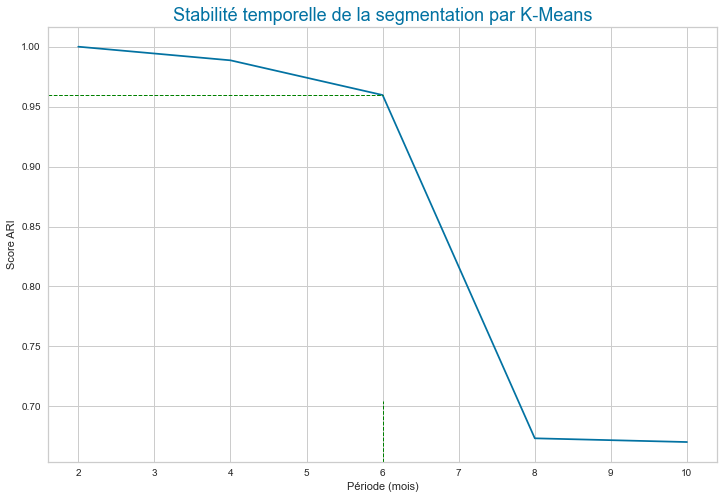

In [52]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.axhline(y=ari_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ari_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores `ARI` obtenus sur les itérations par période de **02 mois**, on remarque une forte inflexion après 6 mois sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 6 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.